## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/sensitivity-analysis-of-dataset-size-vs-model-performance/)) <font size='3ptx'>**Machine learning model performance often improves with dataset size for predictive modeling.**</font>

This depends on the specific datasets and on the choice of model, although it often means that using more data can result in better performance and that discoveries made using smaller datasets to estimate model performance often scale to using larger datasets.

<font color='darkred'>**The problem is the relationship is unknown for a given dataset and model, and may not exist for some datasets and models.**</font> Additionally, if such a relationship does exist, there may be a point or points of diminishing returns where adding more data may not improve model performance or where datasets are too small to effectively capture the capability of a model at a larger scale.

**These issues can be addressed by performing a <font color='darkblue'>sensitivity analysis</font> to quantify the relationship between dataset size and model performance.** Once calculated, we can interpret the results of the analysis and make decisions about how much data is enough, and how small a dataset may be to effectively estimate performance on larger datasets.

**In this tutorial, you will discover how to perform a sensitivity analysis of dataset size vs. model performance.**

After completing this tutorial, you will know:
* Selecting a dataset size for machine learning is a challenging open problem.
* Sensitivity analysis provides an approach to quantifying the relationship between model performance and dataset size for a given model and prediction problem.
* How to perform a sensitivity analysis of dataset size and interpret the results.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into three parts; they are:
* <font size='3ptx'>[**Dataset Size Sensitivity Analysis**](#sect1)</font>
* <font size='3ptx'>[**Synthetic Prediction Task and Baseline Model**](#sect2)</font>
* <font size='3ptx'>[**Sensitivity Analysis of Dataset Size**](#sect3)</font>

In [11]:
# test classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt

<a id='sect1'></a>
## <font color='darkblue'>Dataset Size Sensitivity Analysis</font>
<font size='3ptx'>**The amount of training data required for a machine learning predictive model is an open question.**</font> It depends on your choice of model, on the way you prepare the data, and on the specifics of the data itself.

It depends on your choice of model, on the way you prepare the data, and on the specifics of the data itself.
* [How Much Training Data is Required for Machine Learning?](https://machinelearningmastery.com/much-training-data-required-machine-learning/)

One way to approach this problem is to perform a [**sensitivity analysis**](https://en.wikipedia.org/wiki/Sensitivity_analysis) and discover how the performance of your model on your dataset varies with more or less data. **This might involve evaluating the same model with different sized datasets and looking for a relationship between dataset size and performance or a point of diminishing returns.**

Typically, there is a strong relationship between training dataset size and model performance, especially for nonlinear models. The relationship often involves an improvement in performance to a point and a general reduction in the expected variance of the model as the dataset size is increased.

**Knowing this relationship for your model and dataset can be helpful for a number of reasons, such as:**
* Evaluate more models.
* Find a better model.
* Decide to gather more data.

You can evaluate a large number of models and model configurations quickly on a smaller sample of the dataset with confidence that the performance will likely generalize in a specific way to a larger training dataset.

This may allow evaluating many more models and configurations than you may otherwise be able to given the time available, and in turn, perhaps discover a better overall performing model.

You may also be able to generalize and estimate the expected performance of model performance to much larger datasets and estimate whether it is worth the effort or expense of gathering more training data.

Now that we are familiar with the idea of performing a sensitivity analysis of model performance to dataset size, let’s look at a worked example.

<a id='sect2'></a>
## <font color='darkblue'>Synthetic Prediction Task and Baseline Model</font>
<font size='3ptx'>**Before we dive into a sensitivity analysis, let’s select a dataset and baseline model for the investigation.**</font>

**We will use a synthetic binary** (<font color='brown'>two-class</font>) **classification dataset in this tutorial**. This is ideal as it allows us to scale the number of generated samples for the same problem as needed.

The [make_classification() scikit-learn function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) can be used to create a synthetic classification dataset. **In this case, we will use 20 input features** (<font color='brown'>columns</font>) **and generate 1,000 samples** (<font color='brown'>rows</font>). The seed for the pseudo-random number generator is fixed to ensure the same base “problem” is used each time samples are generated.

The example below generates the synthetic classification dataset and summarizes the shape of the generated data.

In [2]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)

# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


Next, we can evaluate a predictive model on this dataset.

We will use a decision tree ([**DecisionTreeClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) as the predictive model. **It was chosen because it is a nonlinear algorithm and has a high variance**, which means that we would expect performance to improve with increases in the size of the training dataset.

We will use a best practice of [repeated stratified k-fold cross-validation](https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/) to evaluate the model on the dataset, with 3 repeats and 10 folds. The complete example of evaluating the decision tree model on the synthetic classification dataset is listed below.

In [3]:
# evaluate a decision tree model on the synthetic classification dataset

# load dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)

# define model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
model = DecisionTreeClassifier()

# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean Accuracy: 0.821 (0.042)


In this case, we can see that the mean classification accuracy is about 82%.

<a id='sect3'></a>
## <font color='darkblue'>Sensitivity Analysis of Dataset Size</font>
The previous section showed how to evaluate a chosen model on the available dataset.

It raises questions, such as:
> **Will the model perform better on more data?**

More generally, we may have sophisticated questions such as:
> **Does the estimated performance hold on smaller or larger samples from the problem domain?**

These are hard questions to answer, but we can approach them by using a <font color='darkblue'>**sensitivity analysis**</font>. Specifically, we can use a sensitivity analysis to learn:
> **How sensitive is model performance to dataset size?**

Or more generally:
> **What is the relationship of dataset size to model performance?**

There are many ways to perform a sensitivity analysis, but perhaps the simplest approach is to define a test harness to evaluate model performance and then evaluate the same model on the same problem with differently sized datasets.

This will allow the train and test portions of the dataset to increase with the size of the overall dataset. To make the code easier to read, we will split it up into functions. First, we can define a function that will prepare (<font color='brown'>or load</font>) the dataset of a given size. The number of rows in the dataset is specified by an argument to the function.

If you are using this code as a template, this function can be changed to load your dataset from file and select a random sample of a given size.

In [4]:
RANDOM_STATE = 1

# load dataset
def load_dataset(n_samples):
    # define the dataset
    X, y = make_classification(
        n_samples=int(n_samples), 
        n_features=20,
        n_informative=15,
        n_redundant=5,
        random_state=RANDOM_STATE
    )
    return X, y

Next, we need a function to evaluate a model on a loaded dataset. We will define a function that takes a dataset and returns a summary of the performance of the model evaluated using the test harness on the dataset.

This function is listed below, taking the input and output elements of a dataset and returning the mean and standard deviation of the decision tree model on the dataset.

In [5]:
# evaluate a model
def evaluate_model(X, y):
    # define model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # define model
    model = DecisionTreeClassifier()

    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    # return summary stats
    return [scores.mean(), scores.std()]

Next, we can define a range of different dataset sizes to evaluate.

**The sizes should be chosen proportional to the amount of data you have available and the amount of running time you are willing to expend.**

In this case, we will keep the sizes modest to limit running time, from 50 to one million rows on a rough $log_{10}$ scale.

In [6]:
# define number of samples to consider
sizes = [50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]

Next, we can enumerate each dataset size, create the dataset, evaluate a model on the dataset, and store the results for later analysis.

In [10]:
%%time
# evaluate each number of samples
means, stds = list(), list()
with tqdm(total=len(sizes)) as pbar:
    for n_samples in sizes:
        # get a dataset
        X, y = load_dataset(n_samples)

        # evaluate a model on this dataset size
        mean, std = evaluate_model(X, y)

        # store
        means.append(mean)
        stds.append(std)
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:17<00:00, 121.75s/it]

Wall time: 20min 17s


Next, we can summarize the relationship between the dataset size and model performance.

In this case, we will simply plot the result with error bars so we can spot any trends visually.

We will **use the standard deviation as a measure of uncertainty on the estimated model performance**. This can be achieved by multiplying the value by 2 to cover approximately 95% of the expected performance if the performance follows a normal distribution.

This can be shown on the plot as an error bar around the mean expected performance for a dataset size.

<ErrorbarContainer object of 3 artists>

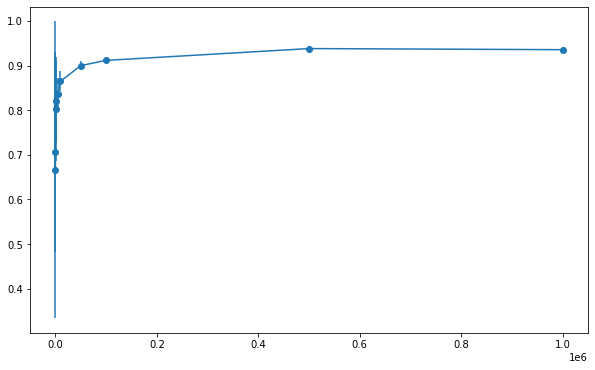

In [18]:
# define error bar as 2 standard deviations from the mean or 95%
err = [min(1, s * 2) for s in stds]

# plot dataset size vs mean performance with error bars
plt.rcParams['figure.figsize'] = [10, 6]
plt.errorbar(sizes, means, yerr=err, fmt='-o')

**To make the plot more readable, we can change the scale of the x-axis to log**, given that our dataset sizes are on a rough log10 scale.

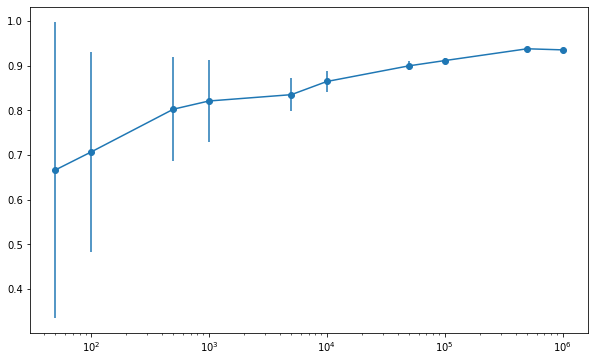

In [20]:
# change the scale of the x-axis to log
plt.errorbar(sizes, means, yerr=err, fmt='-o')
ax = plt.gca()
ax.set_xscale("log", nonpositive='clip')

# show the plot
plt.show()

**We would generally expect mean model performance to increase with dataset size. We would also expect the uncertainty in model performance to decrease with dataset size.**

We can see that there is perhaps a **point of diminishing returns in estimating model performance at perhaps 10,000 or 50,000 rows**.

Specifically, we do see an improvement in performance with more rows, but we can probably capture this relationship with little variance with 10K or 50K rows of data.

<font color='darkred'>**We can also see a drop-off in estimated performance with 1,000,000 rows of data**</font>, suggesting that we are probably maxing out the capability of the model above 100,000 rows and are instead measuring statistical noise in the estimate.

This might mean an upper bound on expected performance and likely that more data beyond this point will not improve the specific model and configuration on the chosen test harness.

**The plot makes the relationship between dataset size and estimated model performance much clearer.**

Given the modest spread with 5,000 and 10,000 samples and the practically log-linear relationship, we could probably get away with using 5K or 10K rows to approximate model performance.

**We could use these findings as the basis for testing additional model configurations and even different model types.**

**The danger is that different models may perform very differently with more or less data and it may be wise to repeat the sensitivity analysis with a different chosen model to confirm the relationship holds**. Alternately, it may be interesting to repeat the analysis with a suite of different model types.